<a href="https://colab.research.google.com/github/marcelogarret/projeto_mestrado/blob/main/LSTM_garret_v0_JAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
from jax import random, grad, vmap, jit, value_and_grad
import flax.linen as nn
from flax.training.train_state import TrainState
import optax
from functools import partial

In [2]:
# Carregar o conjunto de dados
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

In [3]:
df = pd.read_csv(csv_path)
df

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420546,31.12.2016 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
420547,31.12.2016 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
420548,31.12.2016 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2
420549,31.12.2016 23:50:00,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8


In [4]:
df.shape

(420551, 15)

In [5]:
df = df[5::6]

In [6]:
df[:6]

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0
35,01.01.2009 06:00:00,997.71,-9.67,263.66,-10.62,92.7,2.93,2.71,0.21,1.69,2.72,1317.71,0.05,0.50,146.0


In [7]:
df.shape

(70091, 15)

In [8]:
df.index = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')
df.tail()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,,
2016-12-31 19:10:00,31.12.2016 19:10:00,1002.18,-0.98,272.01,-5.36,72.00,5.69,4.09,1.59,2.54,4.08,1280.70,0.87,1.36,190.6
2016-12-31 20:10:00,31.12.2016 20:10:00,1001.40,-1.40,271.66,-6.84,66.29,5.51,3.65,1.86,2.27,3.65,1281.87,1.02,1.92,225.4
2016-12-31 21:10:00,31.12.2016 21:10:00,1001.19,-2.75,270.32,-6.90,72.90,4.99,3.64,1.35,2.26,3.63,1288.02,0.71,1.56,158.7
2016-12-31 22:10:00,31.12.2016 22:10:00,1000.65,-2.89,270.22,-7.15,72.30,4.93,3.57,1.37,2.22,3.57,1288.03,0.35,0.68,216.7
2016-12-31 23:10:00,31.12.2016 23:10:00,1000.11,-3.93,269.23,-8.09,72.60,4.56,3.31,1.25,2.06,3.31,1292.41,0.56,1.00,202.6


<Axes: xlabel='Date Time'>

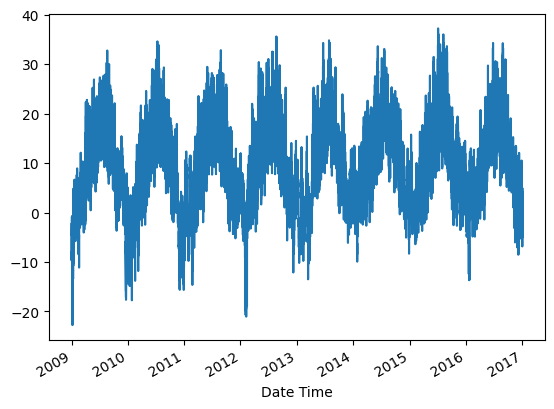

In [9]:
temp = df['T (degC)']
temp.plot()

In [10]:
def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [11]:
WINDOW_SIZE = 5
X, y = df_to_X_y(temp, WINDOW_SIZE)
X.shape, y.shape

((70086, 5, 1), (70086,))

In [12]:
X[0, :, :], y[0]

(array([[-8.05],
        [-8.88],
        [-8.81],
        [-9.05],
        [-9.63]]),
 -9.67)

In [13]:
X_train, y_train = X[:60000], y[:60000]
X_val, y_val = X[60000:65000], y[60000:65000]
X_test, y_test = X[65000:], y[65000:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((60000, 5, 1), (60000,), (5000, 5, 1), (5000,), (5086, 5, 1), (5086,))

In [14]:
# Converter dados para jax.numpy
X_train = jnp.array(X_train)
y_train = jnp.array(y_train)
X_val = jnp.array(X_val)
y_val = jnp.array(y_val)
X_test = jnp.array(X_test)
y_test = jnp.array(y_test)

In [15]:
# # Normalização dos dados entre 0 e 1
# X_min = X_train.min()
# X_max = X_train.max()

# X_train = (X_train - X_min) / (X_max - X_min)
# X_val = (X_val - X_min) / (X_max - X_min)
# X_test = (X_test - X_min) / (X_max - X_min)

In [16]:
X_train[0], y_train[0]

(Array([[-8.05],
        [-8.88],
        [-8.81],
        [-9.05],
        [-9.63]], dtype=float32),
 Array(-9.67, dtype=float32))

In [60]:
# Definir a rede LSTM usando Flax
class LSTM(nn.Module):
    @nn.compact
    def __call__(self, x):
        # LSTM_scan = nn.scan(nn.LSTMCell,
        #            in_axes=1, out_axes=0,
        #            variable_broadcast='params',
        #            split_rngs={'params': False})
        # lstm = LSTM_scan(64)

        input_shape = x[0].shape

        lstm = nn.LSTMCell(64)

        carry0 = lstm.initialize_carry(jax.random.PRNGKey(0), input_shape)
        carry1, out1 = lstm(carry0, x[0])
        carry2, out2 = lstm(carry1, x[1])
        carry3, out3 = lstm(carry2, x[2])
        carry4, out4 = lstm(carry3, x[3])
        _, x = lstm(carry4, x[4])

        # print(x[-1].shape)
        # x = carry[1]
        # print(x.shape)
        x = nn.Dense(8)(x)
        x = nn.relu(x)
        x = nn.Dense(1)(x)
        return x.flatten()

# Initialize the random key
rng_key = random.PRNGKey(42)

class LSTMnet(LSTM):
    def setup(self):
        super().setup()

# Define the Neural Network
model = LSTMnet()
# model = RNNnet()

# Initialize the model parameters
rng_key, init_key = random.split(rng_key, 2)
# dummy_input = jnp.zeros(X_train[0].shape)
dummy_input = X_train[0]
params = model.init(init_key, dummy_input)

## Define the optimizer using Optax
# The learning rate scheduler
# lr = optax.exponential_decay(init_value=1e-3,
#                              transition_steps=5000,
#                              decay_rate=0.98)
lr = 0.05

tx = optax.adam(learning_rate=lr)
# tx = optax.adam(0.001,0.9,0.999,1e-07)

# Create the training state
state = TrainState.create(
    apply_fn=lambda params_, x_: model.apply(params_, x_)[0],
    params=params,
    tx=tx)

# Create the training state
# state = TrainState.create(
#     apply_fn=model.apply,
#     params=params,
#     tx=tx)

In [61]:
# Print the model structure in a fancy way
print(model.tabulate(rng_key, dummy_input))


                                     LSTMnet Summary                                     
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path          ┃ module   ┃ inputs          ┃ outputs         ┃ params                 ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│               │ LSTMnet  │ float32[5,1]    │ float32[1]      │                        │
├───────────────┼──────────┼─────────────────┼─────────────────┼────────────────────────┤
│ LSTMCell_0    │ LSTMCell │ - - float32[64] │ - - float32[64] │                        │
│               │          │   - float32[64] │   - float32[64] │                        │
│               │          │ - float32[1]    │ - float32[64]   │                        │
├───────────────┼──────────┼─────────────────┼─────────────────┼────────────────────────┤
│ LSTMCell_0/ii │ Dense    │ float32[1]      │ float32[64]     │ kernel: float32[1,64]  │
│        

In [62]:
# params['params']

In [63]:
# Solução para 1 exemplo de teste
x_single = jnp.asarray([[0.1], [0.1], [0.1], [0.1], [0.1]])
u = state.apply_fn(state.params, x_single)
u

Array(-0.17567047, dtype=float32)

In [64]:
u.shape

()

In [65]:
# Solução para todo o dataset de treinamento

u_pred_vmap = vmap(state.apply_fn, (None, 0))(state.params, X_train)
u_pred_vmap

Array([0.01196195, 0.01058285, 0.01089728, ..., 0.28516406, 0.3010866 ,
       0.31518936], dtype=float32)

In [66]:
u_pred_vmap.shape

(60000,)

In [67]:
train_batch = {'x': X_train, 'u': y_train}
eval_batch = {'x': X_val, 'u': y_val}

@jit
def loss_fn(params, batch):
  u_pred = vmap(state.apply_fn, (None, 0))(params, batch['x'])
  return jnp.square(u_pred - batch['u']).mean()

@jit
def l2_error(params, batch):
  u_pred = vmap(state.apply_fn, (None, 0))(params, batch['x'])
  return jnp.linalg.norm(x=(u_pred - batch['u']), ord=2) / jnp.linalg.norm(x=batch['u'], ord=2)

@jit
def eval_step(state, batch):
    return l2_error(state.params, batch)

@jit
def train_step(state, batch):
    loss, grads = value_and_grad(loss_fn)(state.params, batch)
    state = state.apply_gradients(grads=grads)
    return loss, state

loss_log = []
epoch_log = []
error_log = []

for epoch in range(50):
  # loss, grads = value_and_grad(loss_fn)(params, train_batch)
  # state = state.apply_gradients(grads=grads)
  loss, state = train_step(state, train_batch)
  epoch_log.append(epoch)
  loss_log.append(loss)
  l2_error = eval_step(state, eval_batch)
  error_log.append(l2_error)
  # print(f"Epoch: {epoch} -- Loss: {loss}")
  print(f"Epoch: {epoch} -- Loss: {loss} -- Error: {l2_error}")

Epoch: 0 -- Loss: 154.7519989013672 -- Error: 0.8918571472167969
Epoch: 1 -- Loss: 137.21409606933594 -- Error: 0.8025819063186646
Epoch: 2 -- Loss: 118.74162292480469 -- Error: 0.701305091381073
Epoch: 3 -- Loss: 98.23228454589844 -- Error: 0.5878780484199524
Epoch: 4 -- Loss: 76.38762664794922 -- Error: 0.4666464328765869
Epoch: 5 -- Loss: 54.05875778198242 -- Error: 0.3534206449985504
Epoch: 6 -- Loss: 33.98252487182617 -- Error: 0.2605637013912201
Epoch: 7 -- Loss: 18.997150421142578 -- Error: 0.19358499348163605
Epoch: 8 -- Loss: 9.515593528747559 -- Error: 0.14398939907550812
Epoch: 9 -- Loss: 4.435665607452393 -- Error: 0.12701058387756348
Epoch: 10 -- Loss: 2.4391980171203613 -- Error: 0.12293748557567596
Epoch: 11 -- Loss: 2.0611977577209473 -- Error: 0.10408693552017212
Epoch: 12 -- Loss: 1.209984302520752 -- Error: 0.10488908737897873
Epoch: 13 -- Loss: 1.0568701028823853 -- Error: 0.10999437421560287
Epoch: 14 -- Loss: 1.1453332901000977 -- Error: 0.11423153430223465
Epoch:

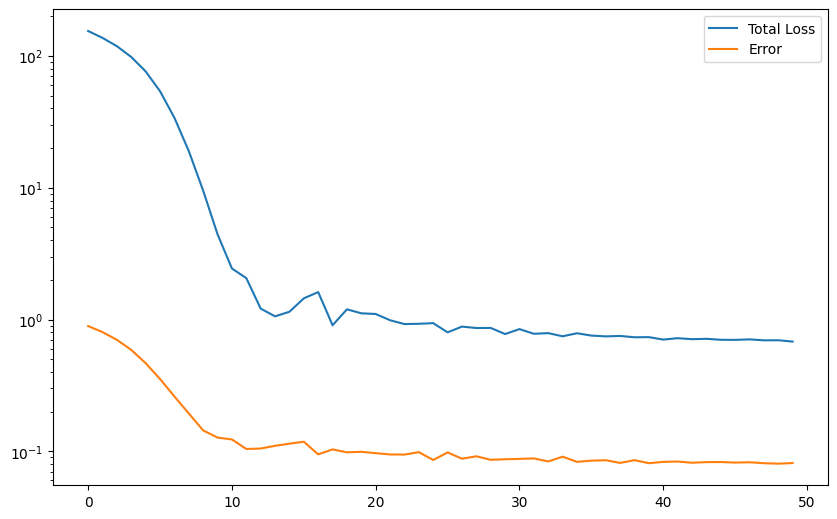

In [69]:
fig, ax = plt.subplots(1,1, figsize=(10,10/1.618))

ax.plot(epoch_log, loss_log, label='Total Loss')
ax.plot(epoch_log, error_log, label='Error')
ax.set_yscale('log')
ax.legend()